<a href="https://colab.research.google.com/github/scottthomaswx/Marine-Obs-Map/blob/main/MarineObsMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture

#Install And Import Packages

!pip install cartopy
!pip install matplotlib
!pip install siphon
!pip install pandas
!pip install geopandas
!pip install metpy

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
from siphon.simplewebservice.ndbc import NDBC
import pandas as pd
import geopandas
from metpy.plots import PlotGeometry
from metpy.units import units
import metpy.calc as mpcalc
import matplotlib as mpl

Note: Small Craft Advisory Thresholds In The Plot Are Calibrated To Great Lakes Levels. Thresholds Can Be Adjusted If The User Desires In Dataframe Query. Thresholds By Region In At: https://github.com/scottthomaswx/Marine-Obs-Map/blob/main/SCY_Thresholds

Note: Great Lakes Mid Lake Buoys (E.g. 45003, 45007, 45008) Only report waves intermitently. If they do not appear when plotting wave heights, it may be the most recent observation did not record waves. Check the last wave ob and whether the most recent reported a wave here: https://www.ndbc.noaa.gov/

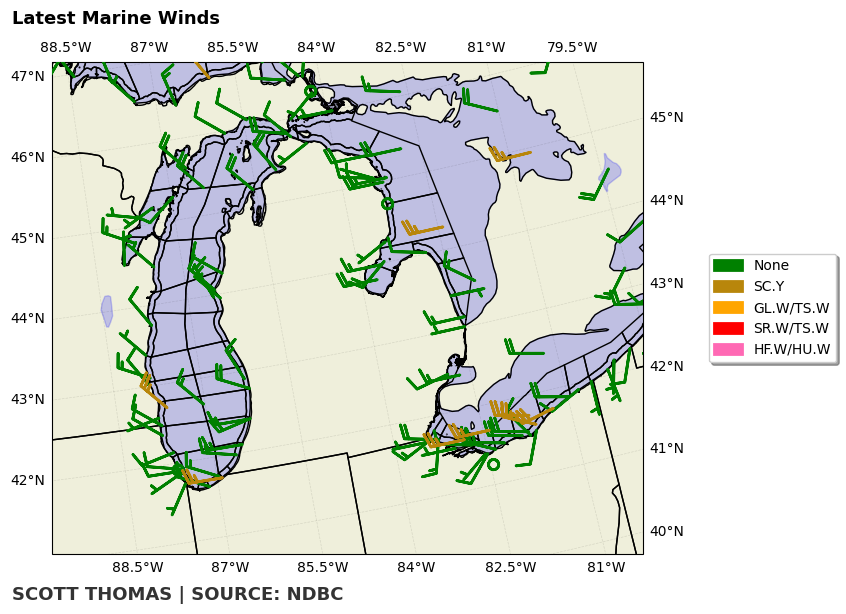

In [38]:
# @markdown ## Check what parameter you wish to plot
# @markdown ### Not all stations will have all variables

#User Selects What Obs They Want To Plot

variable = 'Sustained Wind Speed' # @param ["Wave Height", "Sustained Wind Speed", "Wind Gusts", "Air Temp", "Water Temp"]

#Set Projection
proj = ccrs.LambertConformal(central_latitude=45., central_longitude=-100.,
                             standard_parallels=[30, 60])
#Add Marine Zones for Great Lakes
mzone_file = geopandas.read_file('/vsicurl/https://github.com/scottthomaswx/Marine-Obs-Map/raw/main/mz19se23.shp')
MarZoneMap = PlotGeometry()
MarZoneMap.geometry = mzone_file['geometry']

#Create Figure
fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection=proj)
ax.coastlines('50m', edgecolor='black')
ax.add_feature(cfeat.OCEAN.with_scale('50m'))
ax.add_feature(cfeat.LAND.with_scale('50m'))
ax.set_extent([-89, -80, 41, 46], ccrs.PlateCarree())
lake = cfeat.NaturalEarthFeature('physical', 'lakes', '50m', edgecolor='blue', facecolor='blue', alpha=0.2, zorder = 1)
ax.add_geometries(MarZoneMap.geometry, crs = ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black',  zorder=2)

#If User Selects Wave Height
if variable == 'Wave Height':

  #Pull Latest NDBC Obs
  df = NDBC.latest_observations()

  #Convert to Imperial Units
  df['wave_height_ft'] = (df.wave_height.values*units.meters).to('feet')
  df['wind_speed_kts'] = (df.wind_speed.values*units.meters/units.second).to('knots')
  df['wind_gust_kts'] = (df.wind_gust.values*units.meters/units.second).to('knots')
  df['air_temp_degf'] = (df.air_temperature.values*units.degC).to('degF')
  df['water_temp_degf'] = (df.water_temperature.values*units.degC).to('degF')

  #Drop Stations That Dont Record Wave Height
  df.dropna(subset=['wave_height_ft'], inplace=True)

  #Query By Wave Height

  NoneWave =  df.query('wave_height_ft < 4')
  SCY_Wave = df.query('wave_height_ft >= 4 and  wave_height_ft < 8') #SC.Y
  F8_Wave = df.query('wave_height_ft >= 8 and  wave_height_ft < 10')
  F10_Wave = df.query('wave_height_ft >= 10 and  wave_height_ft < 15')
  F15_Wave = df.query('wave_height_ft >= 15 and  wave_height_ft < 20')
  F20_Wave =df.query('wave_height_ft >= 20')

  #Plot Waves By Magnitide
  ax.scatter(NoneWave['longitude'], NoneWave['latitude'], c='green', label = '< 4 ft',
            transform=ccrs.PlateCarree(), s = 50, zorder = 999, edgecolor = 'black')

  ax.scatter(SCY_Wave['longitude'], SCY_Wave['latitude'], c='darkgoldenrod', label = '4-8 ft (SC.Y)',
            transform=ccrs.PlateCarree(), s = 50,zorder = 999, edgecolor = 'black')

  ax.scatter(F8_Wave['longitude'], F8_Wave['latitude'], c='orange', label = '8-10 ft',
            transform=ccrs.PlateCarree(), s = 50, zorder = 999, edgecolor = 'black')

  ax.scatter(F10_Wave['longitude'], F10_Wave['latitude'], c='red', label = '10-15 ft',
            transform=ccrs.PlateCarree(), s = 50, zorder = 999, edgecolor = 'black')

  ax.scatter(F15_Wave['longitude'], F15_Wave['latitude'], c='hotpink', label = '15-20 ft',
            transform=ccrs.PlateCarree(), s = 50, zorder = 999, edgecolor = 'black')

  ax.scatter(F20_Wave['longitude'], F20_Wave['latitude'], c='purple', label = '20+ ft',
            transform=ccrs.PlateCarree(), s = 50, zorder = 999, edgecolor = 'black')

  #Add Text Based On Plot Ratios
  plt.figtext(0.22, 0.85, f'Latest Wave Heights', ha='left', weight='bold', fontsize=13)
  plt.figtext(0.22, 0.13, f'SCOTT THOMAS | SOURCE: NDBC', weight='bold', color='black', fontsize=13, ha='left', alpha=0.8)

  #Add Legend To Right Of Plot
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box .height])
  ax.legend(loc='center left', bbox_to_anchor=(1.10, 0.5),
      ncol=1, fancybox=True, shadow=True)

#If User Selects Sustained Wind Speed
elif variable == 'Sustained Wind Speed':

  #Pull Latest NDBC Obs
  df = NDBC.latest_observations()

  #Convert to Imperial Units
  df['wave_height_ft'] = (df.wave_height.values*units.meters).to('feet')
  df['wind_speed_kts'] = (df.wind_speed.values*units.meters/units.second).to('knots')
  df['wind_gust_kts'] = (df.wind_gust.values*units.meters/units.second).to('knots')
  df['air_temp_degf'] = (df.air_temperature.values*units.degC).to('degF')
  df['water_temp_degf'] = (df.water_temperature.values*units.degC).to('degF')

  #Remove Stations That Dont Record Sustained Winds
  df.dropna(subset=['wind_speed_kts'], inplace=True)

  #Query Wind Speed By Magnitide

  NoneWind =  df.query('wind_speed_kts < 22') #No Hazard
  SCY_Wind = df.query('wind_speed_kts >= 22 and  wind_speed_kts < 34') #SC.Y
  GLW_Wind = df.query('wind_speed_kts >= 34 and  wind_speed_kts < 48') #GL.W/TS.W
  SRW_Wind = df.query('wind_speed_kts >= 48 and  wind_speed_kts < 64') #SR.W/TS.W
  HFW_Wind = df.query('wind_speed_kts >= 64') #HF.W/HU.W

  #Find U and V Components Of Wind For Barbs
  NoneU, NoneV = mpcalc.wind_components((NoneWind['wind_speed_kts'].values * units ('knots')), (NoneWind['wind_direction'].values * units ('deg')))
  SCYU, SCYV = mpcalc.wind_components((SCY_Wind['wind_speed_kts'].values * units ('knots')), (SCY_Wind['wind_direction'].values * units ('deg')))
  GLWU, GLWV = mpcalc.wind_components((GLW_Wind['wind_speed_kts'].values * units ('knots')), (GLW_Wind['wind_direction'].values * units ('deg')))
  SRWU, SRWV = mpcalc.wind_components((SRW_Wind['wind_speed_kts'].values * units ('knots')), (SRW_Wind['wind_direction'].values * units ('deg')))
  HFWU, HFWV = mpcalc.wind_components((HFW_Wind['wind_speed_kts'].values * units ('knots')), (HFW_Wind['wind_direction'].values * units ('deg')))

  #Plot Barbs Colored By Sustained Wind Magnitude
  ax.barbs(NoneWind['longitude'], NoneWind['latitude'], NoneU, NoneV, barbcolor='green', label = 'None',
            transform=ccrs.PlateCarree(),zorder = 999, linewidth=2)

  ax.barbs(SCY_Wind['longitude'], SCY_Wind['latitude'], SCYU, SCYV, barbcolor='darkgoldenrod', label = 'SC.Y',
            transform=ccrs.PlateCarree(), zorder = 999, linewidth=2)

  ax.barbs(GLW_Wind['longitude'], GLW_Wind['latitude'], GLWU, GLWV, barbcolor='orange', label = 'GL.W/TS.W',
            transform=ccrs.PlateCarree(), zorder = 999, linewidth=2)

  ax.barbs(SRW_Wind['longitude'], SRW_Wind['latitude'], SRWU, SRWV, barbcolor='red', label = 'SR.W/TS.W',
            transform=ccrs.PlateCarree(), zorder = 999, linewidth=2)

  ax.barbs(HFW_Wind['longitude'], HFW_Wind['latitude'], HFWU, HFWV, barbcolor='hotpink', label = 'HF.W/HU.W',
            transform=ccrs.PlateCarree(), zorder = 999, linewidth=2)

  #Add Text Based On Plot Ratios
  plt.figtext(0.22, 0.85, f'Latest Marine Winds', ha='left', weight='bold', fontsize=13)
  plt.figtext(0.22, 0.13, f'SCOTT THOMAS | SOURCE: NDBC', weight='bold', color='black', fontsize=13, ha='left', alpha=0.8)

  #Plot Legend To Right Of Box
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box .height])
  ax.legend(loc='center left', bbox_to_anchor=(1.10, 0.5),
      ncol=1, fancybox=True, shadow=True)

#If User Selects Wind Gusts
elif variable == 'Wind Gusts':

  #Pull Latest NDBC Obs
  df = NDBC.latest_observations()

  #Convert to Imperial Units
  df['wave_height_ft'] = (df.wave_height.values*units.meters).to('feet')
  df['wind_speed_kts'] = (df.wind_speed.values*units.meters/units.second).to('knots')
  df['wind_gust_kts'] = (df.wind_gust.values*units.meters/units.second).to('knots')
  df['air_temp_degf'] = (df.air_temperature.values*units.degC).to('degF')
  df['water_temp_degf'] = (df.water_temperature.values*units.degC).to('degF')

  #Remove Stations That Dont Record Wind Gusts
  df.dropna(subset=['wind_gust_kts'], inplace=True)

  #Query Wind Gusts By Magnitude
  NoneGusts =  df.query('wind_gust_kts < 22') #No Hazard
  SCY_Gusts = df.query('wind_gust_kts >= 22 and  wind_gust_kts < 34') #SC.Y
  GLW_Gusts = df.query('wind_gust_kts >= 34 and  wind_gust_kts < 48') #GL.W/TS.W
  SRW_Gusts = df.query('wind_gust_kts >= 48 and  wind_gust_kts < 64') #SR.W/TS.W
  HFW_Gusts = df.query('wind_gust_kts >= 64') #HF.W/HU.W

  #Calculate U and V Components Of Wind For Barbs
  NoneU, NoneV = mpcalc.wind_components((NoneGusts['wind_gust_kts'].values * units ('knots')), (NoneGusts['wind_direction'].values * units ('deg')))
  SCYU, SCYV = mpcalc.wind_components((SCY_Gusts['wind_gust_kts'].values * units ('knots')), (SCY_Gusts['wind_direction'].values * units ('deg')))
  GLWU, GLWV = mpcalc.wind_components((GLW_Gusts['wind_gust_kts'].values * units ('knots')), (GLW_Gusts['wind_direction'].values * units ('deg')))
  SRWU, SRWV = mpcalc.wind_components((SRW_Gusts['wind_gust_kts'].values * units ('knots')), (SRW_Gusts['wind_direction'].values * units ('deg')))
  HFWU, HFWV = mpcalc.wind_components((HFW_Gusts['wind_gust_kts'].values * units ('knots')), (HFW_Gusts['wind_direction'].values * units ('deg')))

  #Plot Wind Barbs Colored By Gust Magnitude
  ax.barbs(NoneGusts['longitude'], NoneGusts['latitude'], NoneU, NoneV, barbcolor='green', label = 'None',
            transform=ccrs.PlateCarree(),zorder = 999, linewidth=2)

  ax.barbs(SCY_Gusts['longitude'], SCY_Gusts['latitude'], SCYU, SCYV, barbcolor='darkgoldenrod', label = 'SC.Y',
            transform=ccrs.PlateCarree(), zorder = 999, linewidth=2)

  ax.barbs(GLW_Gusts['longitude'], GLW_Gusts['latitude'], GLWU, GLWV, barbcolor='orange', label = 'GL.W/TS.W',
            transform=ccrs.PlateCarree(), zorder = 999, linewidth=2)

  ax.barbs(SRW_Gusts['longitude'], SRW_Gusts['latitude'], SRWU, SRWV, barbcolor='red', label = 'SR.W/TS.W',
            transform=ccrs.PlateCarree(), zorder = 999, linewidth=2)

  ax.barbs(HFW_Gusts['longitude'], HFW_Gusts['latitude'], HFWU, HFWV, barbcolor='hotpink', label = 'HF.W/HU.W',
            transform=ccrs.PlateCarree(), zorder = 999, linewidth=2)

  #Add Text Based On Plot Ratios
  plt.figtext(0.22, 0.85, f'Latest Marine Gusts', ha='left', weight='bold', fontsize=13)
  plt.figtext(0.22, 0.13, f'SCOTT THOMAS | SOURCE: NDBC', weight='bold', color='black', fontsize=13, ha='left', alpha=0.8)

  #Plot Legend To Right Of Box
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box .height])
  ax.legend(loc='center left', bbox_to_anchor=(1.10, 0.5),
      ncol=1, fancybox=True, shadow=True)

#If User Selects Air Temp
elif variable == 'Air Temp':

  #Pull Latest NDBC Obs
  df = NDBC.latest_observations()

  #Convert to Imperial Units
  df['wave_height_ft'] = (df.wave_height.values*units.meters).to('feet')
  df['wind_speed_kts'] = (df.wind_speed.values*units.meters/units.second).to('knots')
  df['wind_gust_kts'] = (df.wind_gust.values*units.meters/units.second).to('knots')
  df['air_temp_degf'] = (df.air_temperature.values*units.degC).to('degF')
  df['water_temp_degf'] = (df.water_temperature.values*units.degC).to('degF')

  #Remove Stations That Dont Measure Air Temp
  df.dropna(subset=['air_temp_degf'], inplace=True)

  #Set Colormap and CMAP Levels
  cmap = plt.cm.hsv_r
  bounds = [-20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

  #Plot Air Temp
  atmp = ax.scatter(df['longitude'], df['latitude'], c=df['air_temp_degf'],
           transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, zorder = 999, s = 50, edgecolor = 'black')

  #Add Colorbar
  plt.colorbar( atmp, label="Air Temperature (DegF)", orientation="vertical", location = 'right')

  #Add Text Based On Plot Ratios
  plt.figtext(0.20, 0.92, f'Latest Marine Air Temp', ha='left', weight='bold', fontsize=13)
  plt.figtext(0.20, 0.06, f'SCOTT THOMAS | SOURCE: NDBC', weight='bold', color='black', fontsize=13, ha='left', alpha=0.8)

#If User Selects Water Temp
elif variable == 'Water Temp':

  #Pull Latest NDBC Obs
  df = NDBC.latest_observations()

  #Convert to Imperial Units
  df['wave_height_ft'] = (df.wave_height.values*units.meters).to('feet')
  df['wind_speed_kts'] = (df.wind_speed.values*units.meters/units.second).to('knots')
  df['wind_gust_kts'] = (df.wind_gust.values*units.meters/units.second).to('knots')
  df['air_temp_degf'] = (df.air_temperature.values*units.degC).to('degF')
  df['water_temp_degf'] = (df.water_temperature.values*units.degC).to('degF')

  #Remove any stations that dont have water temperature
  df.dropna(subset=['water_temp_degf'], inplace=True)

  #Set Color Map and Levels For CMAP
  cmap = plt.cm.hsv_r
  bounds = [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

  #Plot Water Temp
  wtmp = ax.scatter(df['longitude'], df['latitude'], c=df['water_temp_degf'],
           transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, zorder = 999, s = 50, edgecolor = 'black')

  #Plot Colorbar
  plt.colorbar( wtmp, label="Water Temperature (DegF)", orientation="vertical", location = 'right')

  #Add Text Based On Plot Ratios
  plt.figtext(0.20, 0.92, f'Latest Marine Water Temp', ha='left', weight='bold', fontsize=13)
  plt.figtext(0.20, 0.06, f'SCOTT THOMAS | SOURCE: NDBC', weight='bold', color='black', fontsize=13, ha='left', alpha=0.8)

#Add Features To Plot
ax.coastlines(color='black',resolution='10m',zorder=99)
ax.add_feature(cfeat.STATES.with_scale('50m'),edgecolor='black', zorder=9)
ax.add_feature(lake)

#Add Lat Long Grid
gl = ax.gridlines(draw_labels = True, x_inline = False, y_inline = False, rotate_labels = False, linewidth = 0.5, linestyle = '--', color = 'black', alpha = 0.1)
gl.x_labels_top = False
gl.x_labels_bottom = True

#Show Plot
plt.show()


In [39]:
df.query('station=="45007"')

,station,latitude,longitude,wind_direction,wind_speed,wind_gust,wave_height,dominant_wave_period,average_wave_period,dominant_wave_direction,...,water_temperature,dewpoint,visibility,water_level_above_mean,time,wave_height_ft,wind_speed_kts,wind_gust_kts,air_temp_degf,water_temp_degf
140,45007,42.674,-87.026,310.0,8.0,11.0,NaN,NaN,NaN,NaN,...,17.0,2.1,NaN,NaN,2023-10-10 02:00:00+00:00,NaN,15.550756,21.382289,56.3,62.6
